# <center>Продвинутая оптимизация гиперпараметров модели
Один из способов  — это **байесовская оптимизация**. Она отличается от случайного поиска или поиска по сетке тем, что учитывает предыдущие результаты, а не выбирает комбинации из вариантов, не имеющих информации о прошлых оценках.

Существует несколько разных алгоритмов для этого типа оптимизации, но особенно используемым является **Tree-Structured Parzen Estimators (TPE)**.
## Tree-Structured Parzen Estimators (TPE)
1. На каждой итерации алгоритм *TPE* учитывает информацию о прошлых опробованных комбинациях гиперпараметров и только потом принимает решение, какой набор следует попробовать дальше. 

    Чтобы приступить к использованию *TPE*, необходимо выполнить несколько итераций с помощью случайного поиска.
2. На следующем шаге происходит разделение собранных наборов на две группы:
    * в первую группу входят наборы, дающие наилучшие результаты после оценки;
    * во вторую — все остальные.

    На изображении ниже: первая группа — красные точки находятся в области минимума целевой функции; вторая группа — синие точки, все остальные.

    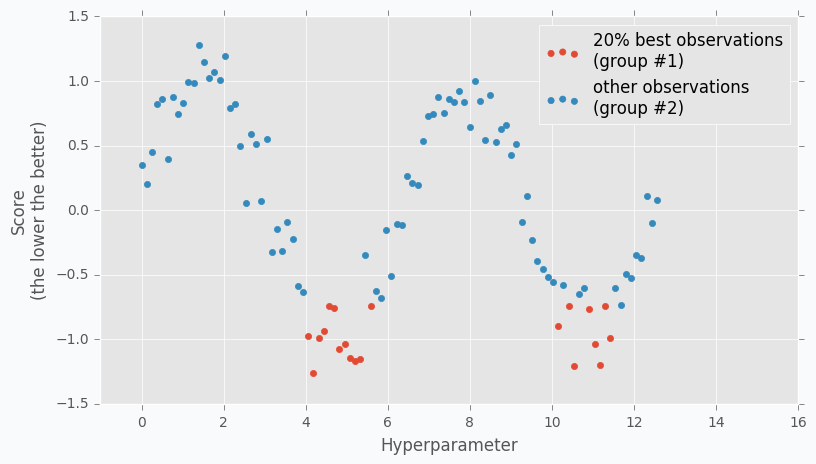

    >Основная цель алгоритма — найти набор гиперпараметров, который с большей вероятностью будет в первой группе и с меньшей вероятностью во второй группе. Таким образом, для принятия следующего решения используется целое распределение наилучших комбинаций — **красные точки** на графике.
3. Далее *TPE* моделирует вероятности правдоподобия для каждой из групп, используя формулу Байеса:
    $$ p(y|x) = \frac{p(x|y) \times p(y)}{p(x)} $$
    где $x$ - гиперпараметры, $y$ - соответствующая оценка качества модели.
4. Затем, используя вероятность правдоподобия из первой группы, отбирается набор комбинаций, которые с большей вероятностью попадут в первую группу и с меньшей вероятностью — во вторую. 
    $$
    p(x|y) = \begin{cases}
                l(x) & \text{if } y<y* \\
                g(x) & \text{if } y \geq y*
             \end{cases}
    $$
    где $p(x|y)$ - это вероятность гиперпараметров с учётом оценки целевой функции, $l(x)$ — вероятность быть в первой группе, $g(x)$ — вероятность быть во второй группе

    Определяем ожидаемое улучшение для каждой комбинации:
    $$ E[I(x)] = \frac{l(x)}{g(x)} $$
    где $E$ — это знак математического ожидания.
5. Шаги 2-4 будут выполняться до тех пор, пока не будет достигнуто максимальное количество итераций. 

В итоге мы найдём **наилучшую комбинацию гиперпараметров**.

## Hyperopt
**Hyperopt** — это библиотека *Python* с открытым исходным кодом на основе байесовской оптимизации, в которой реализован алгоритм *Tree-Structured Parzen Estimators (TPE)*.

Три шага для использования **Hyperopt**:
1. Задание пространства поиска гиперпараметров. 

    Объявляем список гиперпараметров, тип распределения и его границы.

    Основные типы:
    ```python
    hp.choice(label, options) #равновероятный выбор из множества

    hp.randint(label, upper) #случайное целое число; random seed, например 

    hp.uniform(label, low, high) #равномерное непрерывное распределение

    hp.normal(label, mu, sigma) #нормальное непрерывное распределение

    hp.lognormal(mu, sigma) #логнормальное непрерывное распределение
    ```
    Используется для:
    * категориальных — `hp.choice`;
    * целочисленных —  `hp.randit`, `hp.quniform`;
    * непрерывных — аналогично целочисленным и `hp.normal`, `hp.uniform`, `hp.lognormal`, `hp.loguniform`.
2. Задание целевой функции. 

    Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики. Можем минимизировать/максимизировать значение метрики.
3. Задание алгоритма поиска:
    * *Random Search*
    * *Tree of Parzen Estimators (TPE)*
## Использование Hyperopt в Python

In [ ]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

In [ ]:
# зададим пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth' : hp.quniform('max_depth', 15, 26, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
}

In [ ]:
# зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

#100%|██████████| 20/20 [01:10<00:00,  3.50s/it, best loss: -0.7986892215038526]
#Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
#CPU times: user 1min 10s, sys: 183 ms, total: 1min 10s
#Wall time: 1min 10s

In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

#f1_score на обучающем наборе: 0.80
#accuracy на тестовом наборе: 0.86
#f1_score на тестовом наборе: 0.68

>*Hyperopt* продолжит поиск с того места, где он остановился, если мы передадим ему объект `Trials`, который уже содержит информацию о предыдущих запусках.

In [ ]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдущих итерациях) 
# и используем старый trials
best = fmin(
    hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=23, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
)
print("Наилучшие значения гиперпараметров {}".format(best))

#100%|██████████| 3/3 [00:08<00:00,  2.89s/it, best loss: -0.7986892215038526]
#Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}

## Optuna
**Optuna** — это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию алгоритм удаляет комбинации, в которых модель даёт качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как *scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai* и другими.

Три шага для использования *Optuna*: 

1. Задание пространства поиска гиперпараметров.

    Основные функции:

    * `suggest_categorical(name, choices)` — для категориальных гиперпараметров;
    * `suggest_int(name, low, high, step=1, log=False)` — для целочисленных гиперпараметров;
    * `suggest_float(name, low, high, step=None, log=False)` — для непрерывных гиперпараметров;
    * `suggest_uniform(name, low, high)` — для целочисленных и непрерывных гиперпараметров.

    С помощью необязательных аргументов `step` и `log` можно дискретизировать или взять логарифм целочисленных и непрерывных параметров.
2. Задание целевой функции. 

    Создаём модель МО, передаём ей данные и оцениваем её на основе выбранной метрики, можем минимизировать/максимизировать значение метрики. На данном этапе будет обучена модель только на одной комбинации гиперпараметров.
3. Создание объекта исследования **create study**. 

    По умолчанию используется алгоритм поиска **TPE** (есть и другие варианты) и вызов метода `optimize()`, в который передаётся целевая функция, созданная на первом шаге. Выполняется заданное `n_trials` раз, подставляются различные комбинации гиперпараметров.





In [ ]:
import optuna

def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state)
  
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score

In [ ]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

In [ ]:
# Встроенная визуализация
optuna.visualization.plot_optimization_history(study, target_name="f1_score")
optuna.visualization.plot_param_importances(study, target_name="f1_score")
optuna.visualization.plot_contour(
    study,
    params=["max_depth", "n_estimators"],
    target_name="f1_score")

## Сравнение методов оптимизации

|Название|Плюсы|Минусы|
|---|---|---|
|`GridSearchCV`|<p>Простой в использовании, идеален для небольшой сетки гиперпараметров <p> Встроенная кросс-валидация <p> Включает построение итоговой модели на всей обучающей выборке |<p>Перебирает просто все комбинации заданной сетки гиперпараметров <p> Требует много времени и вычислительных ресурсов|
|`RandomizedSearchCV`|<p>Эффективнее и экономичнее *gridsearchcv*<p>Можно задать количество рассматриваемых комбинаций|Просто выбирает рандомные комбинации гиперпараметров без учёта результатов прошлых итераций|
|`Hyperopt`|<p>Быстрее и эффективнее, чем классические методы перебора (*GSCV* и *RSCV*)<p>Учитывает результаты прошлых итераций — байесовский оптимизатор<p>Можно отслеживать дополнительную информацию на каждом шаге с помощью класса Trials<p>Возможность построения условного пространства поиска гиперпараметров и даже моделей|<p>Старая документация, плохо с поддержкой и обновлением<p>Способен только минимизировать<p>Непростой синтаксис описания пространства гиперпараметров (особенно с использованием условных реализаций)|
|`Optuna`|<p>Один из самых быстрых и эффективных<p>Специально разработан для оптимизации гиперпараметров<p>Простой в использовании<p>Относительно новый фреймворк с хорошей документацией<p>Учитывает результаты прошлых итераций — байесовский оптимизатор<p>Встроенная визуализация результатов<p>Возможность явно задавать максимизацию или минимизацию функции качества|<p>Удаление «плохих» точек пространства из рассмотрения<p>Не стоит полностью полагаться: важно с умом определять пространство поиска, что может значительно сократить время расчётов.|